## Классификация сервисов яндекс при помощи модели XGBoost

#### Библиотеки

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV


print("Pandas version: ", pd.__version__)

import sys  

from sklearn.model_selection import train_test_split


Pandas version:  1.4.4


In [2]:
current_path = ''

# current_path = 'iter-20230609/by_balabanov'
df_final_filename = 'data/df_final.csv'

dfFinal = pd.read_csv(df_final_filename)

print('df_final: ', dfFinal.shape)

df_final:  (4693, 40)


In [3]:
dfFinal.dropna(axis=1,inplace=True)

In [4]:
y = dfFinal['type']
drop_col = ['type','proto','diag_step_fiat','diag_step_biat','diag_steps','pktiat_7', 'pktiat_1', 'pktiat_2', 'pktiat_9']
X  = dfFinal.drop(columns=drop_col)

#### Разобьем данные на подопытные и проверочные

In [5]:
X_train, X_test, y_train, y_test = X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        random_state=42,
                                                        stratify=None)

In [6]:
!pip3 install xgboost

Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1129)'))) - skipping


## XGBoost

In [7]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from xgboost import plot_tree

##### Оценщиком выступит XGBoost

In [8]:
estimator = XGBClassifier(
    objective= 'multi:softmax',
    nthread=4,
    seed=42
)

##### ...со следующим набором параметров

In [9]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(20, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05, 0.2]
}

In [10]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = 5,
    cv = 10,
    verbose=1
)

In [11]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 160 candidates, totalling 1600 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=N

In [12]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

In [13]:
predictions_XGB = grid_search.predict(X_test)

In [14]:
print('\nXGBClassifier test accuracy:', accuracy_score(predictions_XGB, y_test))


XGBClassifier test accuracy: 0.8870738636363636


In [15]:
from sklearn.metrics import (confusion_matrix, accuracy_score, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

In [16]:
def plot_confusion_matrix(y_test, prediction, model_name, index=["0", "1", "2"], columns=["0", "1", "2"]):
    cm = confusion_matrix(y_test, prediction)
    cm_df = pd.DataFrame(cm, index, columns)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm_df, annot=True, fmt='g', annot_kws={"size": 10})
    plt.title(model_name+'\nAccuracy:{0:.4f}'.format(accuracy_score(y_test, prediction)))
    plt.ylabel('True Label', fontsize=1)
    plt.show()


def display_confusion_matrix(y_test, prediction, display_labels=["0", "1"]):
    cm = confusion_matrix(y_test, prediction)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    cm_display.plot()
    plt.show()


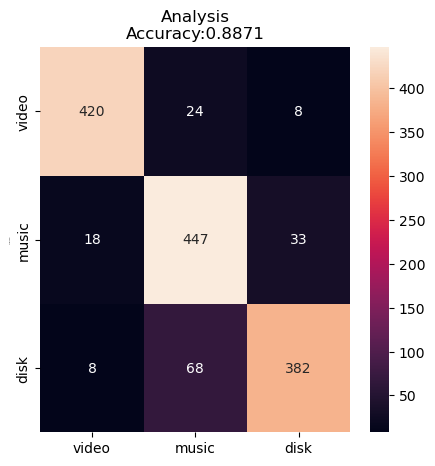

In [17]:
import seaborn as sns
plot_confusion_matrix(y_test, predictions_XGB.round(), "Analysis", index=["video", "music", "disk"], columns=["video", "music", "disk"])

In [18]:
# Make sure to average feature importances! 
feature_importances = grid_search.best_estimator_.feature_importances_ / 2
feature_importances = pd.DataFrame({'feature': list(X.columns),
                                    'importance': feature_importances}
                                  ).sort_values('importance', ascending = False)

feature_importances.head(10)

,feature,importance
4,flow_packets_per_second,0.225163
15,pktlen_8,0.103032
1,f_pkts_num,0.093401
2,min_fiat,0.040156
3,min_biat,0.038248
0,packets_count,0.000000
5,f_min_pkt_size,0.000000
6,b_min_pkt_size,0.000000
7,tcp_syn_count,0.000000
8,tcp_ack_count,0.000000
